# Principal component analysis

Principal component analysis (PCA) is a well-established unsupervised algorithm primarily used for dimensionality reduction (or else, feature extraction) purposes. The difference between feature selection and feature extraction is that in the former  the original features are maintained, whereas the second one is used to transform (or project) the data onto a new feature space.

## A brief description of PCA

PCA helps us identify data patterns based on the correlations between features. More specifically, it focuses on finding the directions of maximum variance in high dimensional data and projects the data onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance (provided that the new feature axes are orthogonal to each other).

In the context of dimensionality reduction, where we desire to project $d$-dimensional vectors into a $k$-dimensional space $(k < d)$, PCA can be summarized in 7 steps:

1. Standardize the original $d$-dimensional dataset $\mathbf{X}$.
2. Construct a symmetric, $d \times d$ covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Sort the eigenvalues in decreasing order to rank the corresponding eigenvectors.
5. Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace.
6. Construct a $d \times k$ projection matrix $\mathbf{W}$, from the "top" $k$ eigenvectors.
7. Transform the $d$-dimensional input dataset $\mathbf{X}$, using the projection matrix $\mathbf{W}$ to obtain the new $k$-dimensional feature subspace.


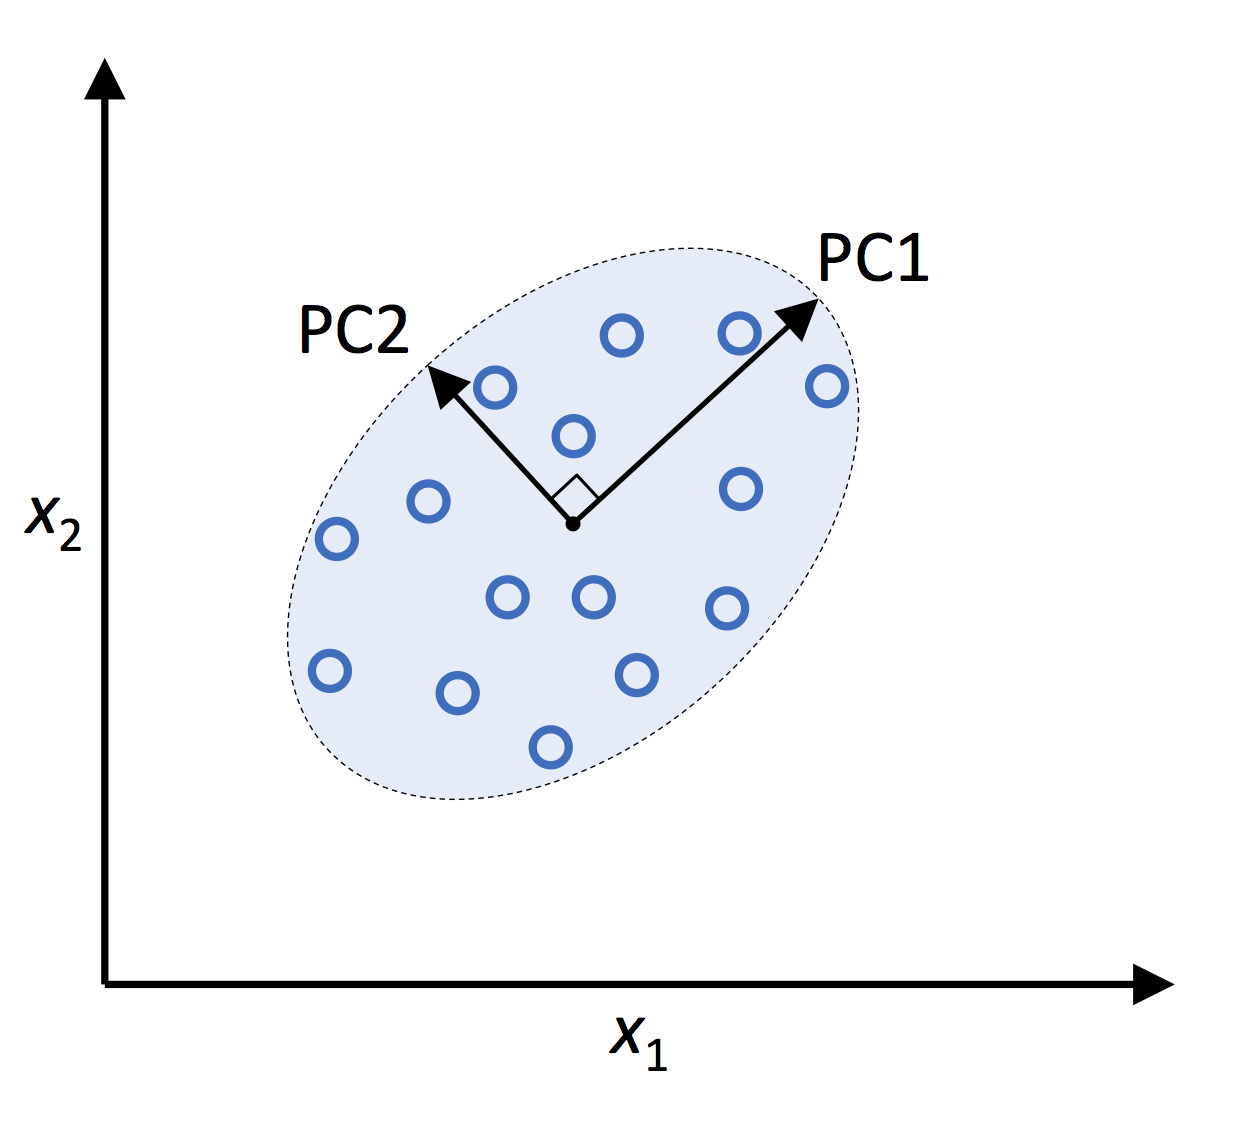

In [1]:
from IPython.display import Image
%matplotlib inline

Image(filename='pca.png', width=400) 

## Extracting the principal components step-by-step

We will use the [Wine](https://archive.ics.uci.edu/ml/machine-learning-databases/wine) dataset in this example. The dataset comes within a single CSV file; this file is initially downloaded from its remote location and then it is stored within a [pandas](https://pandas.pydata.org/) dataframe by invoking the [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) method. 


In [2]:
from io import StringIO
import sys

import pandas as pd
import numpy as np

# This one loads the Wine dataset into a Pandas dataframe
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# The 13 different features in the Wine dataset, describing the chemical properties of the 178 wine examples:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print("Dataset shape:", df_wine.shape)
print("Dataset Class labels:", np.unique(df_wine['Class label']))

df_wine.head(5)


Dataset shape: (178, 14)
Dataset Class labels: [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In the sequel, we apply the well-known [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method to split the original dataset into a training and a test set. 
The sizes of the training and test sets are set equal to 70\% and 30\% of the size of the original dataset, respectively.


In [3]:
from sklearn.model_selection import train_test_split

# The input variables of the dataset: All rows, all columns apart from the first one.
X = df_wine.iloc[:, 1:].values

# The input variables of the dataset: All rows, first column (column index = 0).
y = df_wine.iloc[:, 0].values

# Split the original dataset into a training and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)


## Step 1: Standardization of the original $N$-dimensional dataset

Standarization dictates the scaling of the input variables into the range $[0,1]$ by applying the following transformation:

\begin{equation}
x_i = \frac{x_i - \mu_{x}} {\sigma_x}
\end{equation}

where $\mu_x$ is the median and $\sigma_x$ is the standard deviation.


In [4]:
# Standardization: x_i = (x_i - mu_x) / sigma_x
from sklearn.preprocessing import StandardScaler

# Standardize the input variables in the training and the test set
sc = StandardScaler()

# fit_transform is equivalent to a call of the 'fit' method, followed by a call to the 'transform' method
# X_train_std = sc.fit_transform(X_train)

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print(X_train_std)


[[ 0.71225893  2.22048673 -0.13025864 ... -0.20017028 -0.82164144
  -0.62946362]
 [ 0.88229214 -0.70457155  1.17533605 ...  1.33982592  0.54931269
   1.47568796]
 [ 0.84585645 -0.73022996  1.17533605 ...  1.06806189  0.1308109
   1.62934866]
 ...
 [ 1.02803489  2.29746195 -0.5778911  ... -1.69487249 -1.86068037
  -1.04434751]
 [-1.30384913 -1.08089484 -0.31677217 ...  0.16218176  0.73691694
   0.40313628]
 [-0.40510216  1.29678411  0.05625489 ...  1.06806189  0.73691694
  -0.89683324]]


## Step 2: Construction of a symmetric, $N \times N$ covariance matrix.

The covariance between two features $x_j$ and $x_k$ can be caculated as follows:

\begin{equation}
\sigma_{jk}=\frac{1}{N-1}\sum_{i=1}^N{ \big( x_j^{(i)} - \mu_j \big) \big( x_k^{(i)} - \mu_k\big)}
\end{equation}

The covariance matrix is a square $N \times N$ matrix that at each element $(j,k)$, stores the covariance $\sigma_{jk}$ between $x_j$ and $x_j$.


In [5]:
# cov_mat will have 13 rows and 13 columns
cov_mat = np.cov(X_train_std.T)

print("Covariant Matrix shape:", cov_mat.shape)
# print(cov_mat)


Covariant Matrix shape: (13, 13)


## Step 3: Eigendecomposition of the covariance matrix.

In [6]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print("\nEigenvalues: Shape" , eigen_vals.shape, "\n%s" % eigen_vals)
print("\nEigenvectors: Shape", eigen_vecs.shape, "\n%s" % eigen_vecs)



Eigenvalues: Shape (13,) 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]

Eigenvectors: Shape (13, 13) 
[[-1.37242175e-01  5.03034778e-01 -1.37748734e-01 -3.29610003e-03
   2.90625226e-01 -2.99096847e-01 -7.90529293e-02  3.68176414e-01
   3.98377017e-01 -9.44869777e-02  3.74638877e-01 -1.27834515e-01
   2.62834263e-01]
 [ 2.47243265e-01  1.64871190e-01  9.61503863e-02  5.62646692e-01
  -8.95378697e-02 -6.27036396e-01  2.74002014e-01  1.25775752e-02
  -1.10458230e-01  2.63652406e-02 -1.37405597e-01  8.06401578e-02
  -2.66769211e-01]
 [-2.54515927e-02  2.44564761e-01  6.77775667e-01 -1.08977111e-01
   1.60834991e-01 -3.89128239e-04 -1.32328045e-01 -1.77578177e-01
  -3.82496856e-01  1.42747511e-01  4.61583035e-01  1.67924873e-02
  -1.15542548e-01]
 [ 2.06945084e-01 -1.13529045e-01  6.25040550e-01  3.38187002e-02
  -5.15873402e-02  4.05836452e-02 -2.23999097e-01  4.40592110e-01
   2.43373853

### Total and explained variance

Eigenvalue Variance:
 [0.36951468599607634, 0.1843492705988419, 0.11815159094596984, 0.07334251763785465, 0.06422107821731665, 0.050517244849076534, 0.03954653891241441, 0.026439183169220004, 0.023893192591852935, 0.01629613773725101, 0.013800211221948404, 0.01172226244308595, 0.008206085679091375]

Eigenvalue Cumulative Variance:
 [0.36951469 0.55386396 0.67201555 0.74535807 0.80957914 0.86009639
 0.89964293 0.92608211 0.9499753  0.96627144 0.98007165 0.99179391
 1.        ]


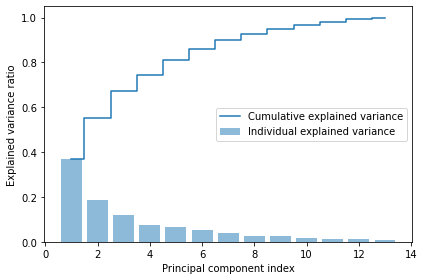

In [7]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals)
sorted_eigen_vals = sorted(eigen_vals, reverse=True)

var_exp = [(i / tot) for i in sorted_eigen_vals]
cum_var_exp = np.cumsum(var_exp)

print("Eigenvalue Variance:\n", var_exp)
print("\nEigenvalue Cumulative Variance:\n", cum_var_exp)

plt.bar(range(1, 14), var_exp, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(1, 14), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc='best')
plt.tight_layout()

plt.show()


## Step 4: Sorting the eigenvalues in decreasing order

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# The above expression is equivalent to the following loop
#eigen_pairs = [()] * len(eigen_vals)
#for i in range(len(eigen_vals)):
#    eigen_pairs[i] = (np.abs(eigen_vals[i]), eigen_vecs[:, i])


# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

eigen_pairs


[(4.842745315655896,
  array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
         -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
         -0.32613263, -0.36861022, -0.29669651])),
 (2.4160245870352295,
  array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
          0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
         -0.20716433, -0.24902536,  0.38022942])),
 (1.548458248820353,
  array([-0.13774873,  0.09615039,  0.67777567,  0.62504055,  0.19613548,
          0.14031057,  0.11705386,  0.13121778,  0.0304309 , -0.07992997,
          0.05305915,  0.13239103, -0.07065022])),
 (0.9612043774977376,
  array([-0.0032961 ,  0.56264669, -0.10897711,  0.0338187 , -0.36751107,
          0.24024513,  0.1870533 , -0.02292622,  0.49626233,  0.10648294,
         -0.36905375,  0.14201609, -0.16768217])),
 (0.8416616104578413,
  array([ 0.29062523, -0.08953787,  0.16083499, -0.05158734, -0.67648707,
          0.11851114, 

## Steps 5, 6: Selection of a value for $k$ and construction of the $N\times k$ projection matrix $\mathbf{W}$

In this example, we set $k=2$, that is, we intend to preserve only 2 from the original 13 features. Therefore, the shape of projection matrix will be equal to $13 \times 2$.


In [9]:
# k = 2: Projection matrix dimensionality (d x 2)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

w_test = np.array( [ eigen_pairs[v][1][:, np.newaxis] for v in range(2) ] )


# k = 3: Projection matrix dimensionality (d x 3)
# w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis], eigen_pairs[2][1][:, np.newaxis]))
print("Matrix W:", w.shape, "\n", w)
print("Matrix W_test:\n", w_test)


Matrix W: (13, 2) 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]
Matrix W_test:
 [[[-0.13724218]
  [ 0.24724326]
  [-0.02545159]
  [ 0.20694508]
  [-0.15436582]
  [-0.39376952]
  [-0.41735106]
  [ 0.30572896]
  [-0.30668347]
  [ 0.07554066]
  [-0.32613263]
  [-0.36861022]
  [-0.29669651]]

 [[ 0.50303478]
  [ 0.16487119]
  [ 0.24456476]
  [-0.11352904]
  [ 0.28974518]
  [ 0.05080104]
  [-0.02287338]
  [ 0.09048885]
  [ 0.00835233]
  [ 0.54977581]
  [-0.20716433]
  [-0.24902536]
  [ 0.38022942]]]


## Step 7: Using $\mathbf{W}$ to project the training set onto a $k$-dimensional space

In [23]:
X_train_pca = X_train_std.dot(w)

X_train_2 = np.matmul(X_train_std, w)

print(X_train_2)
print(X_train_pca)

[[ 2.38299011  0.45458499]
 [-1.96578183  1.65376939]
 [-2.53907598  1.02909066]
 [-1.43010776  0.6024011 ]
 [ 3.14147227  0.66214979]
 [ 0.50253552 -2.08907131]
 [ 0.04867722 -2.27536044]
 [ 2.47888989 -0.08603318]
 [ 2.01900259 -1.3538719 ]
 [ 0.75156583 -2.55367947]
 [ 0.72268915 -1.18404391]
 [-3.00366211  0.94626934]
 [ 2.57518878 -1.0697549 ]
 [ 3.73151104  1.01968876]
 [-1.12276518  0.13877   ]
 [ 2.85996853  2.28819559]
 [-0.74717125 -3.21746061]
 [-1.58427878  0.16048055]
 [ 3.38887101  2.11550689]
 [ 3.15405473  0.54233966]
 [-1.28036506 -1.72926871]
 [-1.71438911  0.71745249]
 [-1.55040291 -1.7580591 ]
 [ 1.10984489 -1.20480693]
 [-0.69108418 -1.71385374]
 [-2.086036   -1.68453671]
 [ 2.90393456  1.95258805]
 [-2.07635784  1.47183304]
 [-1.74756185 -1.25842546]
 [ 2.59424456 -0.1056037 ]
 [-2.50372355  0.70412212]
 [-2.19448402  2.18657552]
 [ 3.91634534  0.16136475]
 [-1.11739618  0.51921086]
 [-0.89996804 -2.04759575]
 [-1.71469178  0.61392169]
 [-2.48581303  0.76839561]
 

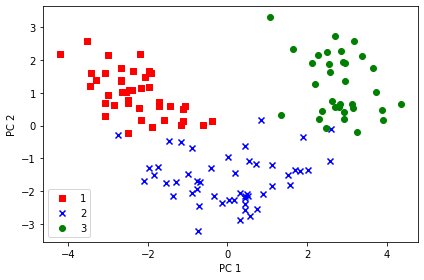

In [11]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()


## Principal Component Analysis in scikit-learn

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is a member of the [sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) object of scikit-learn. It uses Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

Moreover, [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.

Its basic parameter is `n_components` which represents the number of the components to keep. This is the dimensionality of the target (i.e. reduced) space.


In [12]:
# Import PCA from scikit-learn
from sklearn.decomposition import PCA

# Here n_components is not set, so the target space will also have 13 dimensions
pca = PCA()

# Apply it to the input data, after the input data has been standardized
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_


array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

## Model interpretation

As usually, we interpret a scikit-learn model by accessing its attributes. These attributes are filled automatically by the framework after the `fit` or `fit_transform` methods have been invoked.

* `explained_variance_`: A single-dimensional array that stores the variance of the `n_components` largest eigenvalues of the covariance matrix of X. Refer to the `var_exp` array of the previous code example.
* `explained_variance_ratio_`: A single-dimensional array that stores the percentage of variance explained by each of the selected components.  Refer to the `cum_var_exp` array of the previous code example.


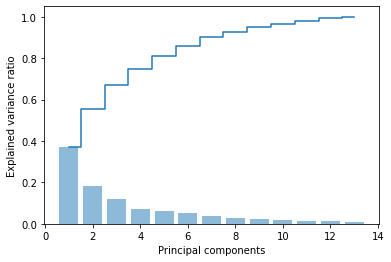

In [13]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align="center")
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where="mid")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")

plt.show()

## Reducing the input space to 2 dimensions

In the following example we perform dimensionality reduction by setting `n_components=2`. Consequently, we project the original input space (with the 13 dimensions) onto a 2-D space by using just two principal components.


In [14]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Dimensionality of the training examples:", X_train_pca.shape)
print("Dimensionality of the test examples:", X_test_pca.shape)

print(pca.components_)

Dimensionality of the training examples: (124, 2)
Dimensionality of the test examples: (54, 2)
[[-0.13724218  0.24724326 -0.02545159  0.20694508 -0.15436582 -0.39376952
  -0.41735106  0.30572896 -0.30668347  0.07554066 -0.32613263 -0.36861022
  -0.29669651]
 [ 0.50303478  0.16487119  0.24456476 -0.11352904  0.28974518  0.05080104
  -0.02287338  0.09048885  0.00835233  0.54977581 -0.20716433 -0.24902536
   0.38022942]]


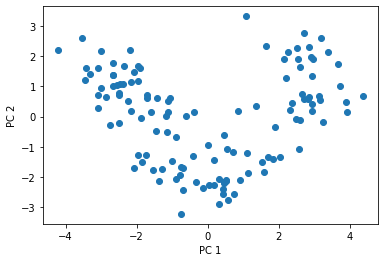

In [15]:
# Project the training examples of the dataset onto a 2-D dimensional space.
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


In [16]:
from matplotlib.colors import ListedColormap

# Plot 2 dimensional spaces and decision boundaries
def plot_decision_regions_2D(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'o', 'v', '^')
    colors = ('red', 'blue', 'lightgreen', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

    # meshgrid: Return coordinate matrices from coordinate vectors. More specifically, we make N-D coordinate arrays
    # for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays.
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    # ravel: Return a contiguous flattened array.
    # T: the transpose matrix
    X_test = np.array([xx1.ravel(), xx2.ravel()]).T
    # print(X_test)

    Z = classifier.predict(X_test)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')


## Training a Logistic Regression classifier with the first 2 principal components.

In [17]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)


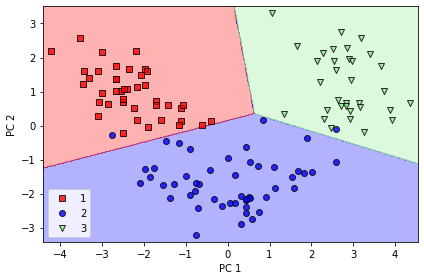

In [18]:
# Plot the training set
plot_decision_regions_2D(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()


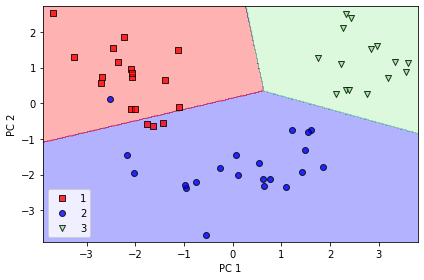

In [19]:
# Plot the test set
plot_decision_regions_2D(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()
